# Loading AP articles and categories

 * Check AP categories available in SPT content (elastic search), make sure we are able to retrieve main sections found on http://www.aftenposten.no
 * Make sure we can join AP view events and article categories
 * First descriptive analysis of article (lifetime) and user (consumption distribution) characteristics
 * Look at a first model of user consumption based on categories

In [22]:
import json
import pandas as pd
from itertools import chain

topics_path = '/Users/Gui/Data/ap_topics_tags.json'
ap_topics_tags = json.load(open(topics_path))
flatten_topic_tags_weights = chain(*[[(topic['id'], tag, weight) for tag, weight in topic['topics'].items()] 
                              for topic in ap_topics_tags])

topics_word_weights = pd.DataFrame.from_records(flatten_topic_tags_weights, columns=['topic', 'word', 'weight'])
topics_word_weights.head()

,topic,word,weight
0,0,utenomjordisk,0.002823
1,0,gang,0.001233
2,0,elven,0.001311
3,0,ismånen,0.001266
4,0,sier,0.001439


In [92]:
top_word_topics = topics_word_weights.groupby('topic').aggregate(lambda x: x.loc[x.weight.argmax()])

top_word_topics.head()

,word,weight
topic,,
0,Månen,0.009971
1,mat,0.011793
2,TV,0.016865
3,20151022,0.009581
4,flyplassen,0.007177


In [127]:
top_word_topics.loc[topic_id, 'word']

u'Kina'

In [128]:
article_path = '/Users/Gui/Data/ap_article_topics_weights.json'
article_topics_weights = json.load(open(article_path))

flatten_article_weights = chain(*[[(article_id, topic_id, weight) for topic_id, weight in enumerate(features)] for article_id, features in article_topics_weights.items()])

article_weights = pd.DataFrame.from_records(flatten_article_weights, columns=['article_id', 'topic', 'weight'])
article_weights.head()

,article_id,topic,weight
0,8071297,0,0.012004
1,8071297,1,0.012004
2,8071297,2,0.012029
3,8071297,3,0.012004
4,8071297,4,0.012004


In [130]:
article_topic_weights = article_weights.pivot(index='article_id', columns='topic', values='weight')
article_topic_weights.columns = top_word_topics['word']
article_topic_weights.head()


word,Månen,mat,TV,20151022,flyplassen,cannabis,bandet,Fosse,Libya,Regjeringen,...,F,Volkswagen,politiet,Høie,Polen,fradrag,Ine,brannen,Tyrkia,aksjonen
article_id,,,,,,,,,,,,,,,,,,,,,
7078955,0.130663,0.001561,0.002885,0.027943,0.001466,0.002180,0.001355,0.006787,0.009550,0.001485,...,0.001436,0.001528,0.002172,0.001426,0.012796,0.003523,0.004633,0.160728,0.001546,0.005856
7410513,0.004112,0.004241,0.005148,0.014101,0.138775,0.004335,0.086518,0.004309,0.040316,0.013965,...,0.090646,0.006370,0.004078,0.005910,0.004420,0.003977,0.010938,0.004521,0.004702,0.014966
7495968,0.007329,0.008113,0.006991,0.007394,0.006981,0.007111,0.008433,0.006722,0.008197,0.006906,...,0.007359,0.006921,0.007326,0.006914,0.007307,0.006752,0.006580,0.007710,0.008051,0.008400
7693926,0.003540,0.002537,0.023897,0.007313,0.002625,0.002674,0.002401,0.002435,0.016637,0.012157,...,0.002702,0.002595,0.002579,0.002423,0.209780,0.002431,0.001889,0.002451,0.002383,0.002975
7696060,0.001376,0.001648,0.001823,0.003144,0.001384,0.005621,0.001648,0.001187,0.001344,0.001282,...,0.005027,0.001575,0.001347,0.001215,0.300379,0.001249,0.004682,0.001180,0.001170,0.001990


# Loading AP user/article view events

In [109]:
events_file = "~/Data/collapsed_events_30_days.csv"
user_events = pd.read_csv(events_file, header=None, names=['ts', 'type', 'user', 'item'], parse_dates=['ts'])

print("{} views from {} x {} user/articles from {} to {}".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape,
        user_events.ts.min(),
        user_events.ts.max()))

2389103 views from (149065,) x (38953,) user/articles from 2015-09-15 23:59:54 to 2015-10-15 23:59:36


In [131]:
events_with_article_content = user_events.item.isin(article_topic_weights.index)
user_events = user_events.ix[events_with_article_content.values,:]

print("{} events with content from {} x {} user/articles".format(
        user_events.shape[0],
        user_events.user.unique().shape,
        user_events.item.unique().shape))
user_events.head()

48542 events with content from (27202,) x (5084,) user/articles


,ts,type,user,item
33,2015-10-04 12:19:04,View,275319,8040236
37,2015-10-02 18:45:00,View,3578529,8066092
109,2015-10-12 08:15:10,View,1195125,8029816
141,2015-09-27 03:46:15,View,4600660,8136492
147,2015-10-01 05:28:27,View,3662095,8111097


# Joining article views and categories

In [132]:
user_events_with_topics = pd.merge(
    user_events,
    article_topic_weights.reset_index(),
    left_on='item',
    right_on='article_id')
    
user_events_with_topics.head(5)

,ts,type,user,item,article_id,Månen,mat,TV,20151022,flyplassen,...,F,Volkswagen,politiet,Høie,Polen,fradrag,Ine,brannen,Tyrkia,aksjonen
0,2015-10-04 12:19:04,View,275319,8040236,8040236,0.002004,0.001443,0.001647,0.005121,0.002399,...,0.002221,0.132334,0.001388,0.001727,0.011557,0.00171,0.000977,0.001282,0.001591,0.001666
1,2015-09-20 13:44:16,View,4640099,8040236,8040236,0.002004,0.001443,0.001647,0.005121,0.002399,...,0.002221,0.132334,0.001388,0.001727,0.011557,0.00171,0.000977,0.001282,0.001591,0.001666
2,2015-09-21 13:42:50,View,2055954,8040236,8040236,0.002004,0.001443,0.001647,0.005121,0.002399,...,0.002221,0.132334,0.001388,0.001727,0.011557,0.00171,0.000977,0.001282,0.001591,0.001666
3,2015-09-21 10:13:34,View,2100450,8040236,8040236,0.002004,0.001443,0.001647,0.005121,0.002399,...,0.002221,0.132334,0.001388,0.001727,0.011557,0.00171,0.000977,0.001282,0.001591,0.001666
4,2015-09-21 06:29:16,View,1973968,8040236,8040236,0.002004,0.001443,0.001647,0.005121,0.002399,...,0.002221,0.132334,0.001388,0.001727,0.011557,0.00171,0.000977,0.001282,0.001591,0.001666


In [143]:
user_totals = user_events_with_topics.groupby('user').size()
user_totals.head()

user
100018    2
100043    1
100176    3
100197    2
100229    1
dtype: int64

## Views per category

In [136]:
pd.DataFrame(user_events_with_topics.iloc[:, 5:].sum(), columns=['views']).sort_values('views', ascending=False).head(20)

,views
Khuu,3108.429519
psykisk,1882.068008
mat,1694.783346
Eia,1690.790971
kirken,1591.110207
TV,1324.716882
Regjeringen,1248.533033
politiet,1236.698147
Polen,1234.323628
20151022,1053.836146


## Number of views per user

## User as mixture of categories

In [140]:
user_topics_sums = user_events_with_topics.groupby('user').sum().iloc[:,5:]

user_topics_probs = user_topics_sums.div(user_topics_sums.sum(axis=1), axis=0)

user_topics_probs.head()

,cannabis,bandet,Fosse,Libya,Regjeringen,data,politiet,psykisk,Coop,Kina,...,F,Volkswagen,politiet,Høie,Polen,fradrag,Ine,brannen,Tyrkia,aksjonen
user,,,,,,,,,,,,,,,,,,,,,
100018,0.002168,0.001246,0.002254,0.001420,0.006118,0.001579,0.001409,0.003081,0.002022,0.002531,...,0.002349,0.080316,0.002056,0.003109,0.020286,0.001855,0.003621,0.001485,0.004530,0.001747
100043,0.019411,0.002859,0.002395,0.002567,0.002357,0.003119,0.002341,0.002428,0.371091,0.005110,...,0.003691,0.003519,0.042687,0.002757,0.018833,0.006014,0.016510,0.002349,0.014175,0.004280
100176,0.003124,0.002474,0.032891,0.002276,0.004859,0.001685,0.005769,0.003422,0.002865,0.003447,...,0.002511,0.002725,0.001871,0.002475,0.007621,0.002884,0.001493,0.006072,0.002096,0.003372
100197,0.001684,0.002016,0.006551,0.001589,0.023409,0.001094,0.002203,0.002395,0.007216,0.001813,...,0.002406,0.007149,0.001332,0.010260,0.107733,0.007501,0.007506,0.142387,0.001583,0.001776
100229,0.001782,0.000932,0.001233,0.000646,0.005506,0.000745,0.000806,0.001304,0.002909,0.000617,...,0.001086,0.000721,0.000608,0.000633,0.001722,0.000818,0.000653,0.001849,0.000609,0.000645


## Representing users in the category space

politiet    0.667687
politiet    0.667687
Eia         0.415101
psykisk     0.306748
Khuu        0.278387
dtype: float64


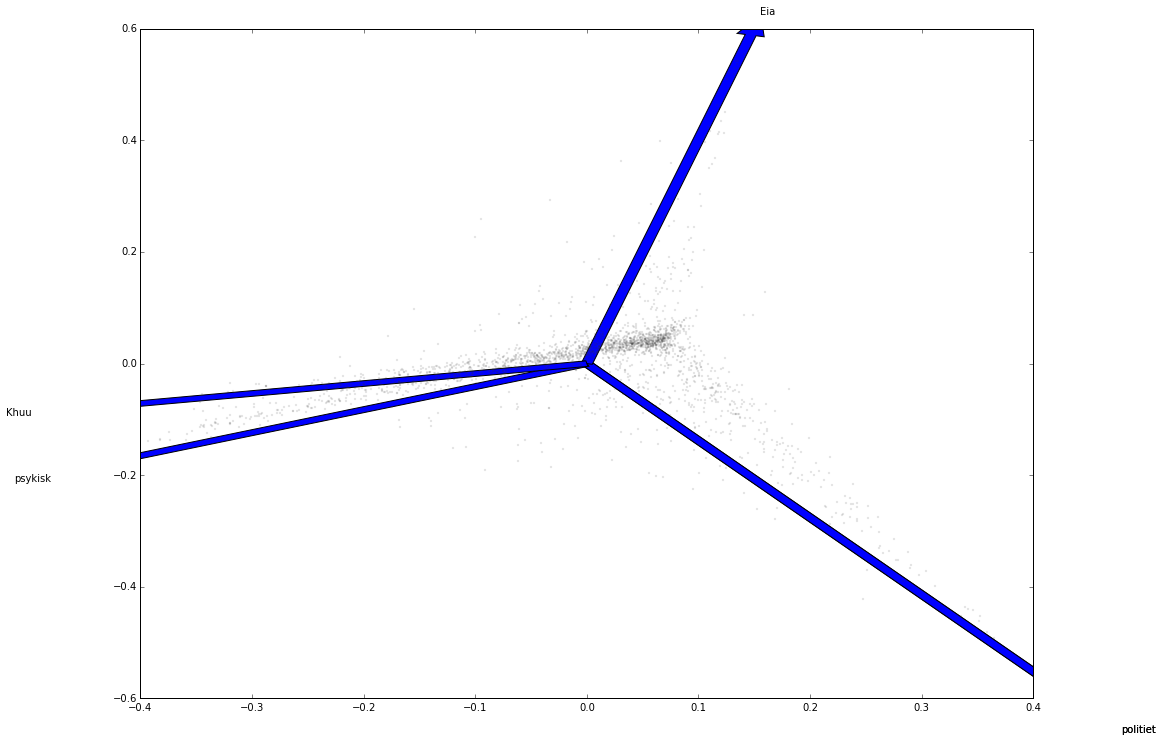

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA

plt.figure(figsize=(16, 12))
pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_topics_probs.values[user_totals.values > 3,:])

plt.plot(user_2d[:,0], user_2d[:,1], 'ko', markeredgecolor='grey', ms=2, alpha=.1)

base_topics = user_topics_probs.columns.tolist()
def topics_to_canonical_array(topics, base_topics=base_topics):
    return np.array([1 if t in topics else 0 for t in base_topics])

topics_2d = pd.DataFrame(
    data=np.array([pca.transform(topics_to_canonical_array([topic]))[0] for topic in base_topics]),
    index=base_topics)

n = 5
topn_topics = topics_2d.apply(
    lambda row: np.power(row[0], 2) + np.power(row[1], 2), axis=1).sort_values(ascending=False).iloc[:n]
print topn_topics
for topic in topn_topics.index:
    point = topics_2d.loc[topic].values
    if len(point.shape) > 1:
        point = point[0,:]
    plt.text(*point, s=topic)
    plt.arrow(0, 0, point[0], point[1], width=0.01, length_includes_head=True, head_width=0.025)

In [187]:
topics_2d.loc['Eia'].values[0,:]

IndexError: too many indices for array